In [5]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as T
import matplotlib.patches as patches

# Data Visulization

In [2]:
data = pd.read_csv('finding_annotations.csv')
data

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20481,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training
20482,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training
20483,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training
20484,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training


/home/admin/miniconda3/envs/conpro/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/admin/miniconda3/envs/conpro/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/admin/miniconda3/envs/conpro/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

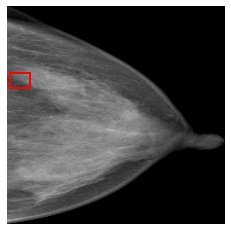

In [6]:
csv_path = 'finding_annotations.csv'
df = pd.read_csv(csv_path)
image_id = df['image_id'][200]
image_data = df[df['image_id'] == image_id]
image_path = f'Processed_Images/{image_data.iloc[0]["study_id"]}/{image_id}.png'
image = Image.open(image_path)
original_width = image_data.iloc[0]['width']
original_height = image_data.iloc[0]['height']
new_size = (224, 224)
image_resized = image.resize(new_size)
x_scale = new_size[0] / original_width
y_scale = new_size[1] / original_height
image_data['xmin_resized'] = image_data['xmin'] * x_scale
image_data['ymin_resized'] = image_data['ymin'] * y_scale
image_data['xmax_resized'] = image_data['xmax'] * x_scale
image_data['ymax_resized'] = image_data['ymax'] * y_scale

fig, ax = plt.subplots(1)

ax.imshow(image_resized)

for idx, row in image_data.iterrows():
    xmin, ymin, xmax, ymax = row['xmin_resized'], row['ymin_resized'], row['xmax_resized'], row['ymax_resized']
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()


# Dataloader

In [7]:
class BreastCancerDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='training', transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.annotations = self.annotations[(self.annotations['split'] == self.split) &
                                            (self.annotations['finding_categories'] != "['No Finding']")]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_id = self.annotations.iloc[idx]['image_id']
        img_path = os.path.join(self.root_dir, 
                                self.annotations.iloc[idx]['study_id'], 
                                f'{img_id}.png')
        
        image = Image.open(img_path).convert("RGB")
        
        original_width = self.annotations.iloc[idx]['width']
        original_height = self.annotations.iloc[idx]['height']
        
        # Resize the image
        new_size = (224, 224)
        image_resized = image.resize(new_size)
        x_scale = new_size[0] / original_width
        y_scale = new_size[1] / original_height
        boxes = []
        temp = self.annotations[self.annotations['image_id'] == img_id]
        for _, row in temp.iterrows():
            xmin = row['xmin'] * x_scale
            ymin = row['ymin'] * y_scale
            xmax = row['xmax'] * x_scale
            ymax = row['ymax'] * y_scale
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        if self.transform:
            image_resized = self.transform(image_resized)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return image_resized, target

transform = T.Compose([
    T.ToTensor(),
])

train_dataset = BreastCancerDataset(csv_file='finding_annotations.csv', 
                                    root_dir='Processed_Images', 
                                    split='training', 
                                    transform=transform)

test_dataset = BreastCancerDataset(csv_file='finding_annotations.csv', 
                                   root_dir='Processed_Images', 
                                   split='test', 
                                   transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Training

## Metric

In [8]:
def calculate_iou(gt_boxes, pred_boxes):
    intersection_area = torch.zeros((gt_boxes.shape[0], pred_boxes.shape[0]))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            x_min = max(gt_box[0], pred_box[0])
            y_min = max(gt_box[1], pred_box[1])
            x_max = min(gt_box[2], pred_box[2])
            y_max = min(gt_box[3], pred_box[3])
            intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
            union = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1]) + (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1]) - intersection
            intersection_area[i][j] = intersection / union
    return intersection_area

def precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    
    matched_gt = set()
    
    for pred_idx, pred_box in enumerate(pred_boxes):
        pred_label = pred_labels[pred_idx]
        pred_score = pred_scores[pred_idx]
        
        ious = calculate_iou(gt_boxes, pred_box.unsqueeze(0))
        best_iou, best_gt_idx = ious.max(dim=0)
        
        if best_iou >= iou_threshold and best_gt_idx.item() not in matched_gt:
            if gt_labels[best_gt_idx] == pred_label:
                tp += 1
                matched_gt.add(best_gt_idx.item())
            else:
                fp += 1
        else:
            fp += 1
    
    fn = len(gt_boxes) - len(matched_gt)
    
    return tp, fp, fn

def calculate_metrics(predictions, ground_truths, iou_threshold=0.5):
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']
        
        gt_boxes = gt['boxes']
        gt_labels = gt['labels']
        
        tp, fp, fn = precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
    
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    
    return precision, recall

## Model

## Faster R-ViT

### Backbone

In [9]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if window_size:
            self.window_size = window_size
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))

            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += window_size[0] - 1
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class RelativePositionBias(nn.Module):
    def __init__(self, window_size, num_heads):
        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))

        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = \
            torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
        relative_position_index[1:, 1:] = relative_coords.sum(-1)
        relative_position_index[0, 0:] = self.num_relative_distance - 3
        relative_position_index[0:, 0] = self.num_relative_distance - 2
        relative_position_index[0, 0] = self.num_relative_distance - 1

        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self):
        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1] + 1,
                self.window_size[0] * self.window_size[1] + 1, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        return relative_position_bias


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=None, init_values=None, use_abs_pos_emb=True, use_rel_pos_bias=False,
                 use_shared_rel_pos_bias=False, out_indices=[0, 1, 2, 3], pretrained=None, **kwargs):
        super().__init__()
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.out_indices = out_indices
        self.pretrained = pretrained

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.use_abs_pos_emb = use_abs_pos_emb
        if self.use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
            trunc_normal_(self.pos_embed, std=.02)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.use_rel_pos_bias = use_rel_pos_bias
        self.use_shared_rel_pos_bias = use_shared_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        if self.use_rel_pos_bias:
            if self.use_shared_rel_pos_bias:
                self.rel_pos_bias = RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
            else:
                self.rel_pos_bias = nn.ModuleList([
                    RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
                    for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.use_abs_pos_emb:
            x = torch.cat((cls_token, x), dim=1) + self.pos_embed
        else:
            x = torch.cat((cls_token, x), dim=1)
        x = self.pos_drop(x)

        if self.use_rel_pos_bias:
            for i, blk in enumerate(self.blocks):
                if self.use_shared_rel_pos_bias:
                    x = blk(x, rel_pos_bias=self.rel_pos_bias())
                else:
                    x = blk(x, rel_pos_bias=self.rel_pos_bias[i]())
        else:
            for blk in self.blocks:
                x = blk(x)
        x = self.norm(x)
        return x[:, 1:]


### Build model

In [10]:
class CustomBackbone(nn.Module):
    def __init__(self, vit_model, img_size=224, patch_size=16):
        super(CustomBackbone, self).__init__()
        self.vit = vit_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.out_channels = vit_model.embed_dim

    def forward(self, x):
        x = self.vit(x)
        batch_size, seq_len, embed_dim = x.shape
        h, w = self.img_size // self.patch_size, self.img_size // self.patch_size
        x = x.permute(0, 2, 1).contiguous().view(batch_size, embed_dim, h, w)
        out = OrderedDict([('0', x)])
        return out

In [11]:
vit_model = VisionTransformer()
custom_backbone = CustomBackbone(vit_model)

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone=custom_backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)


## Faster R-CNN

In [27]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2 
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [28]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(224,), max_size=224, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

## Training

In [12]:
import torch.optim as optim
from tqdm import tqdm

def train(model, optimizer, train_dataloader, device):
    model.train()
    train_loss_classifier = 0.0
    train_loss_box_reg = 0.0
    train_loss_objectness = 0.0
    train_loss_rpn_box_reg = 0.0
    
    train_progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for images, targets in train_progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        
        # Accumulate individual losses
        train_loss_classifier += loss_dict['loss_classifier'].item()
        train_loss_box_reg += loss_dict['loss_box_reg'].item()
        train_loss_objectness += loss_dict['loss_objectness'].item()
        train_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()
        
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_progress_bar.set_postfix(classifier=train_loss_classifier / (len(train_progress_bar) + 1),
                                       box_reg=train_loss_box_reg / (len(train_progress_bar) + 1),
                                       objectness=train_loss_objectness / (len(train_progress_bar) + 1),
                                       rpn_box_reg=train_loss_rpn_box_reg / (len(train_progress_bar) + 1))

    num_batches = len(train_dataloader)
    train_loss_classifier /= num_batches
    train_loss_box_reg /= num_batches
    train_loss_objectness /= num_batches
    train_loss_rpn_box_reg /= num_batches
    
    return train_loss_classifier, train_loss_box_reg, train_loss_objectness, train_loss_rpn_box_reg


def evaluate(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_ground_truths = []
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            predictions = model(images)
        
        all_predictions.extend(predictions)
        all_ground_truths.extend(targets)
    
    precision, recall = calculate_metrics(all_predictions, all_ground_truths)
    return precision, recall



In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    train_loss_classifier, train_loss_box_reg, train_loss_objectness, train_loss_rpn_box_reg = train(model, optimizer, train_dataloader, device)
    print(f"Training Loss Classifier: {train_loss_classifier:.4f}, "
          f"Box Reg: {train_loss_box_reg:.4f}, "
          f"Objectness: {train_loss_objectness:.4f}, "
          f"RPN Box Reg: {train_loss_rpn_box_reg:.4f}")

    
    precision, recall = evaluate(model, test_dataloader, device)
    print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}")


Epoch 1/100


Training:   0%|          | 0/451 [00:00<?, ?it/s]/home/admin/miniconda3/envs/conpro/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

# Testing

In [45]:
import torch

# Assuming 'test_dataloader' is your data loader for testing

# Get a batch of images and labels from the data loader
imgs, tgs = next(iter(test_dataloader))

# Move the images to the device (GPU, if available)
imgs = [image.to(device) for image in imgs]

# Convert labels to device-compatible format
tgs = [{k: v.to(device) for k, v in t.items()} for t in tgs]

# Set the model to evaluation mode
model.eval().cuda()

# Pass the images through the backbone
with torch.no_grad():
    # Extract features from the backbone
    backbone_outputs = model.backbone(torch.stack(imgs))
print(backbone_outputs.shape)
# # Print the shape of each feature map in the backbone output
# for key, value in backbone_outputs.items():
#     print(f"Shape of {key} feature map:", value.shape)


torch.Size([4, 768])


In [19]:
imgs, tgs = next(iter(test_dataloader))
model.eval()
preds = model(imgs)
preds[0]['boxes']
# imgs[0]

/home/admin/miniconda3/envs/conpro/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


IndexError: list index out of range

In [61]:
imgs[0].shape

torch.Size([3, 224, 224])

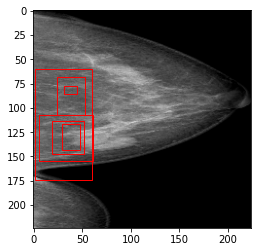

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import numpy as np

# Define a function to plot the image with bounding boxes
def plot_image_with_boxes(image, boxes):
    # Convert torch tensor to numpy array and permute dimensions
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # Create figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    # Add bounding boxes to the image
    for box in boxes:
        # Extract box coordinates
        xmin, ymin, xmax, ymax = box
        
        # Calculate box width and height
        width = xmax - xmin
        height = ymax - ymin
        
        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the plot
        ax.add_patch(rect)
    
    # Show plot
    plt.show()

# Example usage
plot_image_with_boxes(imgs[0], preds[0]['boxes'])
